<a href="https://colab.research.google.com/github/Ryan-Radawiec/Machine-Learning-Projects/blob/master/Implement_Vanilla_Gan_on_MNIST_Dataset_to_Generate_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    
    
device 

device(type='cuda')

In [73]:
noise_dim=100

# Generator Class

In [74]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fcn=torch.nn.Sequential(
            #Fully connected Layer 1
            torch.nn.Linear(
                in_features=noise_dim,
                out_features=1200, #has 1200 neurons
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(), #dropout used for regularization. Helps through training
                #Fully Connected Layer 2
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=1200,
                out_features=784,
                bias=True
            ),
            torch.nn.Sigmoid()
        )
            
    def forward(self, batch):  #forward pass
        ret = batch.view(batch.size(0), -1) #make two dimensional matrix, -1 matches whatever size the data is
        ret = self.fcn(ret) #pass batch through fully connected network
        return ret #return the output
                

# MaxOut Class

In [75]:
class MaxOut(torch.nn.Module):
    def __init__(self, num_pieces):
        super(MaxOut, self).__init__()
        self.num_pieces = num_pieces
        
    def forward(self, x):
        #x.shape = (batch_size? x 625)
        assert x.shape[1] % self.num_pieces == 0 #625 % 5 = 0
        
        ret = x.view(
            *x.shape[:1], #bath size
            x.shape[1] // self.num_pieces,      #piecewise linear
            self.num_pieces,      #num pieces
            *x.shape[2:]    #remaining dimensions if any    
        )
        #ret.shape = batch_size? x 125 x 5)
        
        ret,_=ret.max(dim=2) #use the max feature
        
        return ret

# Discriminator Class

In [76]:
#Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fcn = torch.nn.Sequential(
            # Fully connected Layer 1
            torch.nn.Linear(
                in_features = 784,
                out_features=625,
                bias=True
            ),
            MaxOut(5),
            #Fully connected Layer 2
            torch.nn.Linear(
                in_features=125,
                out_features=625,
                bias=True
            ),
            MaxOut(5),
            #Fully connected Layer 3
            torch.nn.Linear(
                in_features=125,
                out_features = 1,
                bias=True
            ),
            torch.nn.Sigmoid() #0 is fake sample, 1 is real sample
        )
    def forward(self, batch):
        ret = batch.view(batch.size(0), -1) #reshape to get 2 dimensional vecto
        ret = self.fcn(ret) #apply fully connected vector to ret
        return ret
        

# Flatten Transform
        

In [77]:
class FlattenTransform: #turns two dimensional images to one dimensional flat vector
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)
    
data_train = torchvision.datasets.MNIST( #import dataset from torchvision
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([ #convert to tensor 0-255 to 0-1 range
        torchvision.transforms.ToTensor(), #returns a pytorch tensor
        FlattenTransform() #apply a flatten transform
    ])
)    

## Training set loader

In [78]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader( #loads the data
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

## GAN Training

In [79]:
generator = Generator().to(device) #sets to 'cpu' in this instance
discriminator = Discriminator().to(device)

discriminator_optimizer = torch.optim.SGD( #sets up the optimizer
    discriminator.parameters(),
    lr=0.005,
    momentum=0.7
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.005,
    momentum=0.7
)
criterion = torch.nn.BCELoss() #binary cross entropy loss for loss function

In [97]:
real_labels = torch.ones(BATCH_SIZE, 1).to(device) #sends 2 dimensional tensor with columns batchsize and 1 to the device
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device) # sends a 2 dimensional tensor to populate as 0s for FALSE cases

test_set = torch.randn(16, noise_dim).to(device) #this fixes the noise to run along training epochs a consistent way to see how the network evolves with time
#uses 16 samples and the second imension is noise dimension



num_epochs = 128 #should be 512
num_steps = len(train_loader) // BATCH_SIZE #length of train loader divided by batch size

In [98]:
import os

if not os.path.exists('visuals'):
    os.mkdir('visuals')

## Training

In [99]:
for epoch in range(num_epochs):
    for i, (images,_) in enumerate(train_loader):
        print('epoch number: {}'.format(epoch))   
        if i == num_steps: #has to break loop so it doesn't go forever
            break
            
        #Train discriminator
        for _ in range(16): #discriminator is trained 16 times more than the generator
            
            real_images = images.to(device) #real images converted to device
            
            fake_images = generator(
                torch.randn(BATCH_SIZE, noise_dim).to(device) #fake images will come from the generator #input to generator is random noise. Give it dimensions
            )
            
            discriminator_optimizer.zero_grad() #sets the gradients to 0
            
            real_outputs = discriminator(real_images)
            fake_outputs = discriminator(fake_images) #give fake images to discriminator
            
            d_x = criterion(real_outputs, real_labels) #aplly loss funciton for real outputs
            d_g_z = criterion(fake_outputs, fake_labels) #apply loss function for fake outputs which is 0s
            
            d_x.backward() #this can be related to the real data with x
            d_g_z.backward()# this can be related to the generated data. These need backward passes to be done on them
            
            discriminator_optimizer.step() #poerforms the actual update of the weights
        
        
        #Train Generator    
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)  #random noise tensor of 2 dimensions and convert to device and save to z
        
        generator.zero_grad() #reinitialize gradients
        
        outputs = discriminator(generator(z)) #pass the noise to generator, output of generator passed to discriminator and the output will be saved to variable outputs
        
        loss = criterion(outputs, real_labels) #determines if the output is real or 1s
        
        loss.backward() #does a backward pass to calculate gradients
        
        generator_optimizer.step() #updates the weights
        
    
    
    #visualize results
    if epoch % 10 ==0:
        #every 10 epochs
        ##detaches gpu to cpu
        #reshape using the view dimension
        #first dimension is batch size
        #secoind dimension channel = 1 grayscale
        #third is dimension width
        #fourth is dimension height
        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)
        
        grid = torchvision.utils.save_image( #creates grid of images and saves to file
            generated,
            os.path.join(
            'visuals',
            '{}.jpg'.format(
                str(epoch).zfill(6) # use zero filling of 6 zeros in case we want to try more than 10000 generations
            )
        ),
        nrow=4, #number of rows for the grid
        padding=10, #padding of 10 pixels for each image
        pad_value=1    #color value will be one or white pixels
    )                                                   
            

Streaming output truncated to the last 5000 lines.
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 43
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 44
epoch number: 

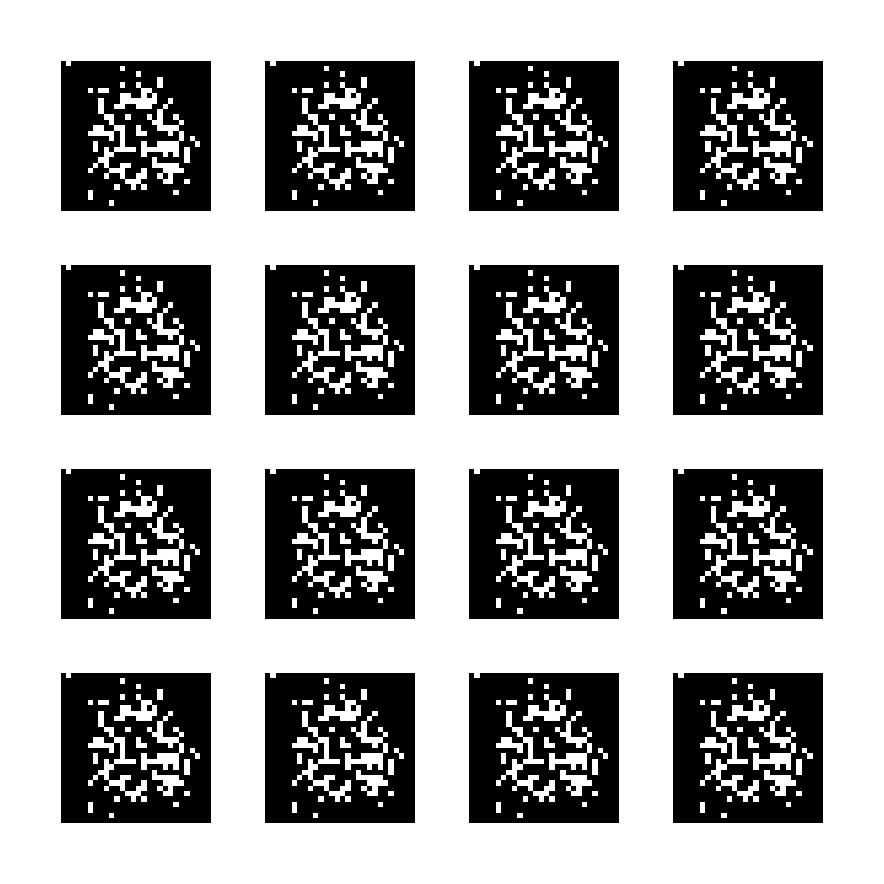

In [100]:
#visualize Results
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28) #use the generator that was trained for 512 epochs
#detach from gpu to cpu using detach
#reshape using view
#first dimension batch_size -1 to autofill
#second dimension for number of channels = 1 for grayscale
#dimensions of image are 28x28 for third and fourth dimensions



grid = torchvision.utils.make_grid( #returns grid variables This one will return a tensor
    generated,
    nrow=4,
    padding=10,
    pad_value=1
)

img = np.transpose( #convert from pytorch tensor to numpy tensor. Have to use tranpose for it to work in matplotlib
    grid.numpy(),
    (1,2,0) 
)

fig = plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(img);

Link to google cloud if you want to run this on a gpu in the cloud

notebook: https://colab.research.google.com/drive/14zSDErgZ8cNn9UEHgh2x2tPhao9HVYn5


# Evaluation Metrics

In [93]:
import math
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3

#Initialize pretrained netowrk
net = inception_v3(pretrained=True).to(device)

def inception_score(images, batch_size):
    
    #list of scores
    scores = []
    
    #number of steps
    num_steps = int(math.ceil(float(len(images)) / float(batch_size)))
    
    #iterate over the images
    for i in range(num_steps):
        
        #mini-batch start and end index
        s = i * batch_size
        e = (i+1) * batch_size
        
        #Mini-batch images
        mini_batch = images[s:e]
        
        #mini-batch as torch tensor with gradients
        batch = Variable(mini_batch)
        
        
        #apply a forward pass through inception network
        # skipping aux logits
        '''
        This network is unique because it has two output layers when the se
        '''
        
        s,_ = net(batch)
        
        #accumulate scores
        scores.append(s)
        
    #stack the scores as tensor
    scores = torch.cat(scores, 0 )
    
    #calculate inception score
    
    '''
    The formula for inception socre 
    IS(x) = E[ KL( P(y|x) || P(y)) ]
    x: generated images
    y: inception model classification distribution aka softmax
    '''
    
    #calculate p(y\x) across dimension 1
    #that is one row for each image
    p_yx = F.softmax(scores, 1)
    
    #calculate p(y) across dimension 0
    # that is one column for each class / label
    p_y = p_yx.mean(0).unsqueeze(0).expand(p_yx.size(0), -1)
    
    #calculate KL divergence
    KL_d = p_yx * (torch.log(p_yx) - torch.log(p_y))
    
    #calculate mean aka expected of KL
    final_score = KL_d.mean()
    
    #return final score
    return final_score
        

In [94]:
#test inception score on generated images
#generate images
images = generator(test_set)

#reshape to 1x28x28
images = images.view(-1, 1, 28, 28)

#repear Gray channel to RGB
images = images.repeat(1,3,1,1)

#resize the images to 3x299x299
res_images = F.interpolate(images, size=(299, 299))

#calculate inception score
score = inception_score(res_images, BATCH_SIZE)

# get value from tensor variable
score.item()

0.00021580801694653928

In [106]:
import math
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3
import scipy
import scipy.linalg as la

#inception v3 feature extractor
class PartialInceptionNetwork(torch.nn.Module):

  def __init__(self):
    #trigger parent constructor
    super(PartialInceptionNetwork, self).__init__()

    #initialize pretrained network
    self.inception_network = inception_v3(pretrained=True)

    #register a forward hook, othrewise not implemented exception
    self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)

  def output_hook(self, module, input, output):
   #N x 2048x 8 x 8
   self.mixed_7c_output = outputs

  def forward(self, x):
      """
      Args:
          x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
      Returns:
          inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
      """
      assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                            ", but got {}".format(x.shape)

      # Trigger output hook
      self.inception_network(x)

      # Output: N x 2048 x 8 x 8 
      activations = self.mixed_7c_output

      # Output: N x 2048 x 1 x 1 
      activations = torch.nn.functional.adaptive_avg_pool2d(
          activations, (1,1))

      # Rectify dimensions
      activations = activations.view(x.shape[0], 2048)

      return activations                                     
# initialize pretrained inception network
net = PartialInceptionNetwork().to(device)


def fid_score(real_images, gen_images, batch_size):

  # list of features
  real_activations = []
  gen_activations = []

  # number of steps
  num_steps = int(math.ceil(float(len(real_images)) / float(batch_size)))

  # iterate over the images
  for i in range(num_steps):

    # mini-batch start and end index
    s = i * batch_size
    e = (i + 1) * batch_size

    # mini-batch images
    mini_batch_real = real_images[s:e]
    mini_batch_gen = gen_images[s:e]
    
    # mini-batch as Torch tensor with gradients
    batch_real = Variable(mini_batch_real)
    batch_gen = Variable(mini_batch_gen)

    # apply a forward pass through inception network
    features_real = net(batch_real)
    features_gen = net(batch_gen)

    # accumulate features
    real_activations.append(features_real)
    gen_activations.append(features_gen)
  
  # stack tensor
  features_real = torch.cat(real_activations, 0)
  features_gen = torch.cat(gen_activations, 0)

  # tensor to numpy
  xr = features_real.detach().cpu().numpy()
  xg = features_gen.detach().cpu().numpy()

  # calculate mean
  u1 = np.mean(xr, axis=0)
  u2 = np.mean(xg, axis=0)

  # calculate variance
  s1 = np.cov(xr, rowvar=False)
  s2 = np.cov(xg, rowvar=False)

  # difference squared
  diff = u1 - u2
  diff_squared = diff.dot(diff)

  # trace covariance product
  prod = s1.dot(s2)
  sqrt_prod, _ = la.sqrtm(prod, disp=False)
  
  # avoid imaginary numbers
  if np.iscomplexobj(sqrt_prod):
    sqrt_prod = sqrt_prod.real

  prod_tr = np.trace(sqrt_prod)

  # calculate FID
  final_score = diff_squared + np.trace(s1) + np.trace(s2) - 2 * prod_tr

  # return final score
  return final_score  

In [108]:


#test FID score


#REAL Images

#load mini batch from dataset
images,_ = next(iter(train_loader))

#convert to GPU
images = images.to(device)

#reShape to 1x28x28
images = images.view(-1, 1, 28, 28)
#repeat Gray channel to RGB
images = images.repeat(1, 3, 1, 1)

#resize the images to 3x299x299
real_res_images = F.interpolate(images, size = (299, 299))

#Generated images

#generate images
images = generator(test_set)

#reshape to 1x28x28
images = images.view(-1, 1, 28, 28)

#repeat Gray channel to RGB
images = images.repeat(1, 3, 1, 1)

# resize the images to 3x299x299
gen_res_images = F.interpolate(images, size=(299, 299))

#calculate the inception score
score = fid_score(real_res_images, gen_res_images, BATCH_SIZE)

#get the value from tensor variable
score

RuntimeError: ignored